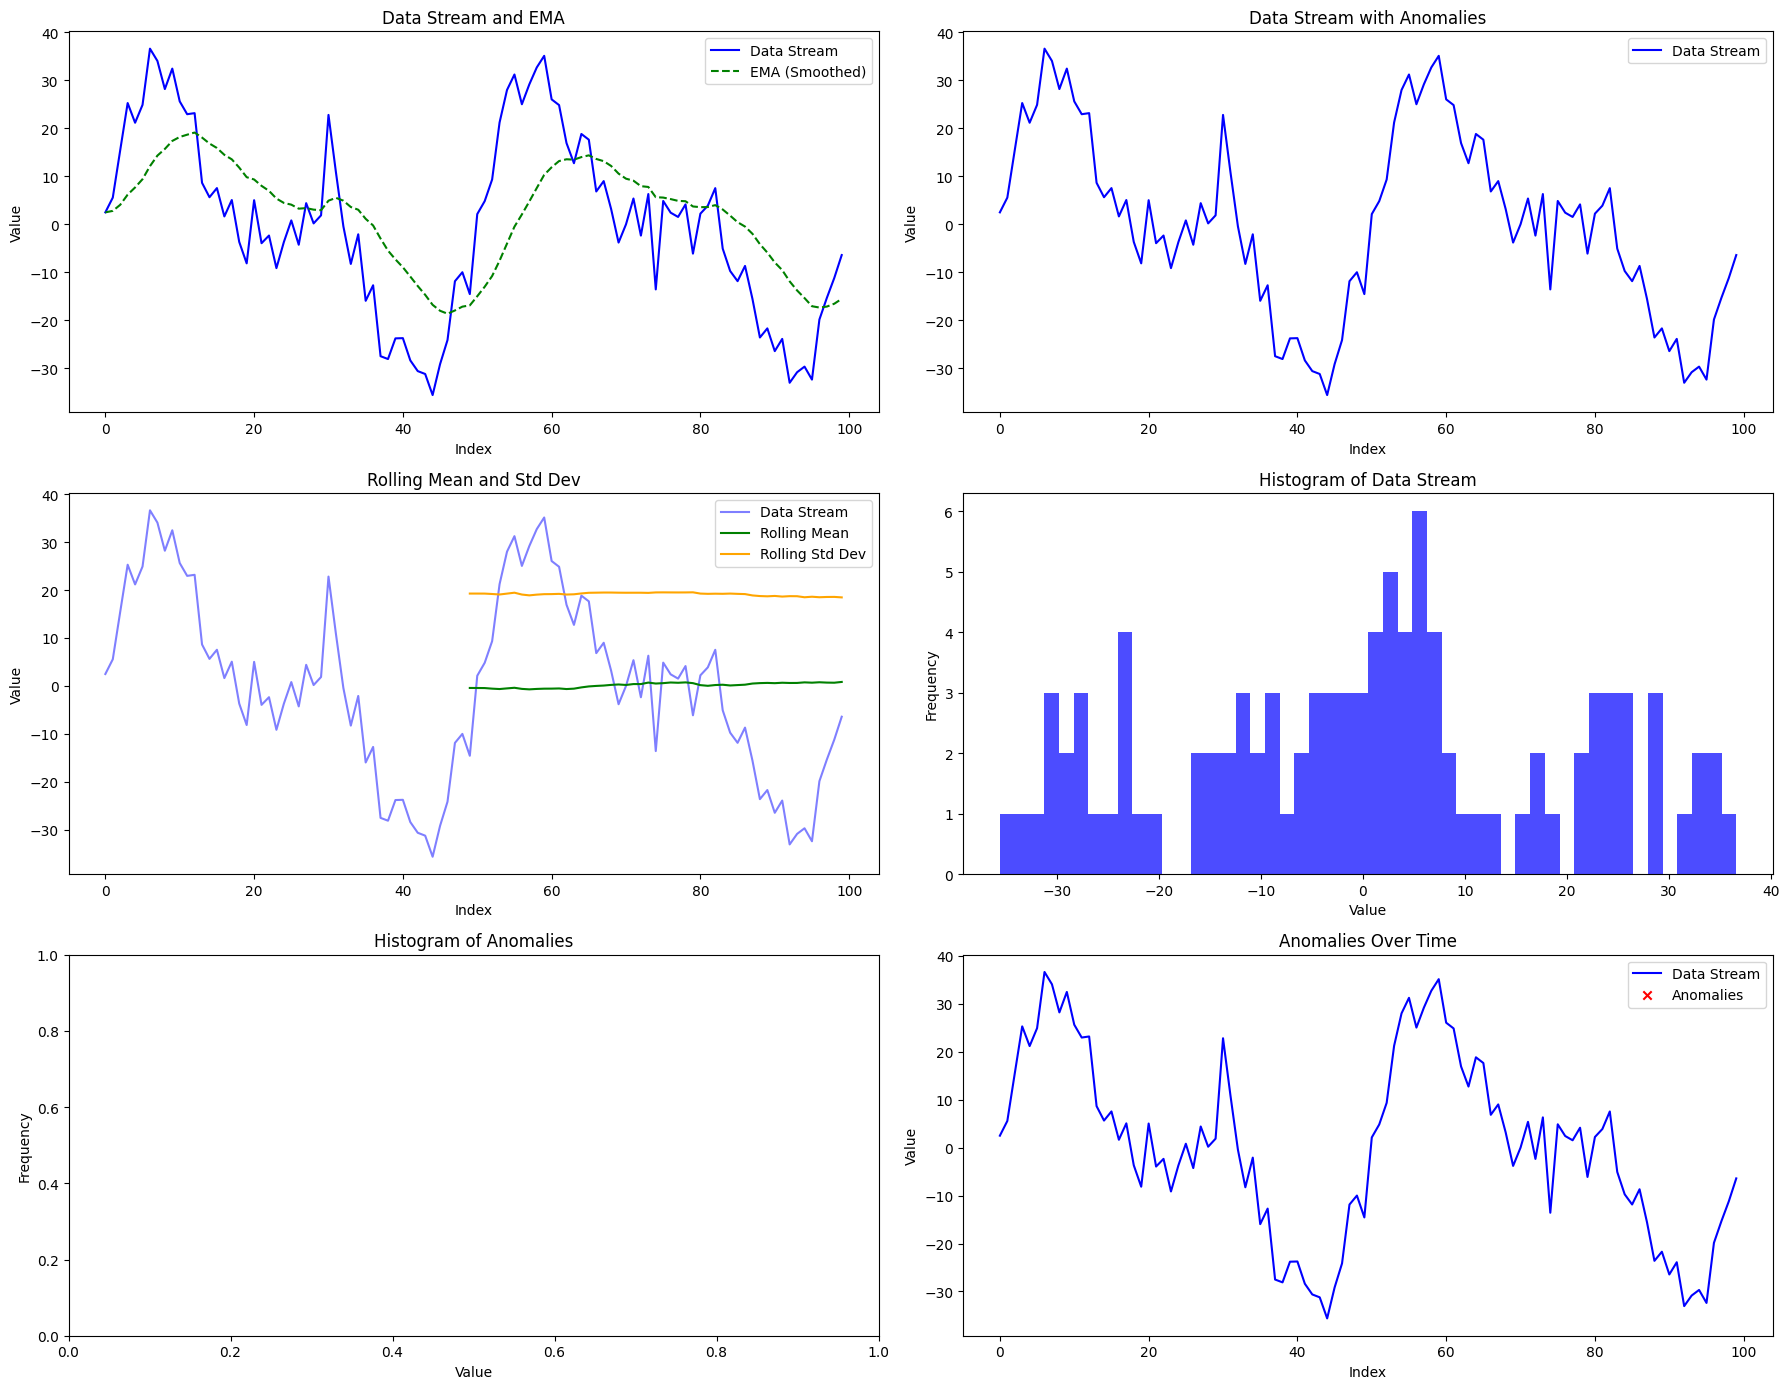

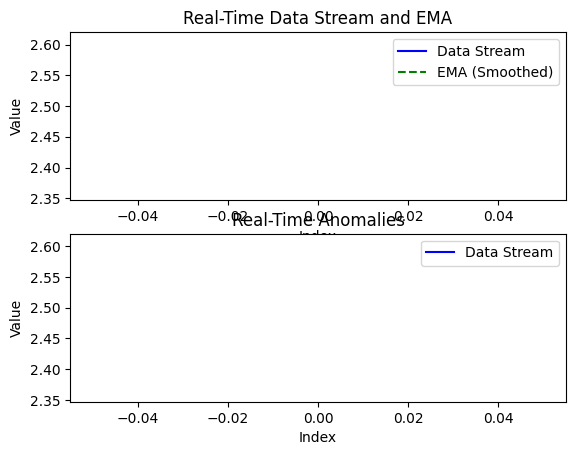

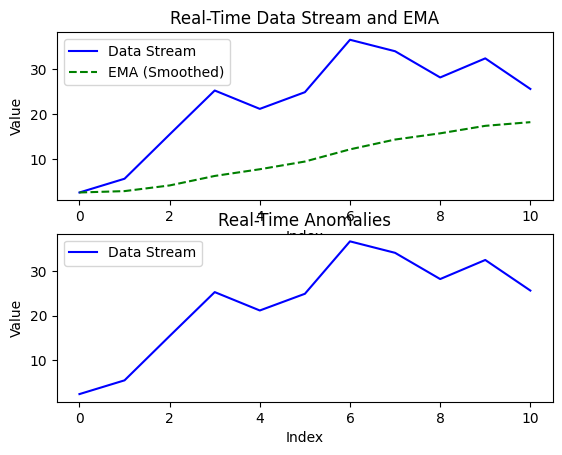

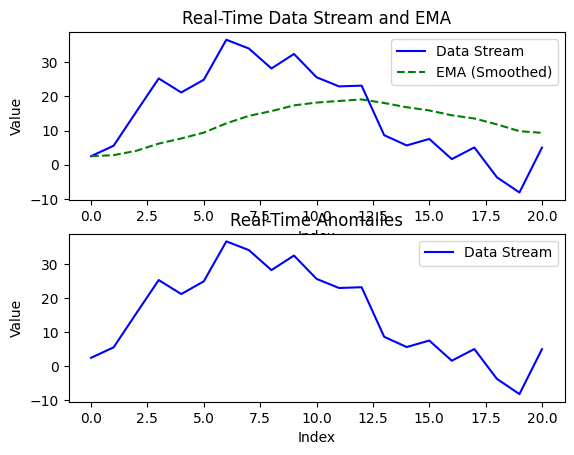

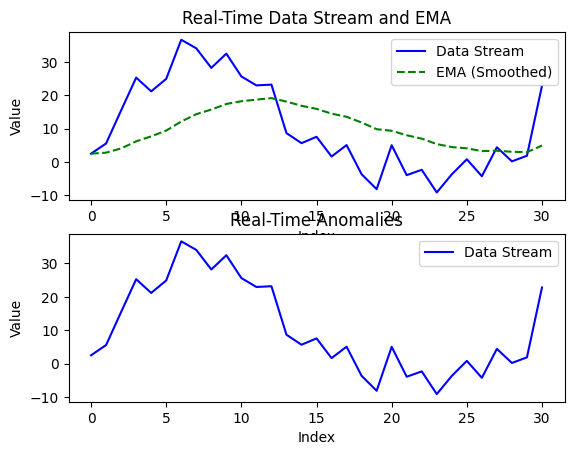

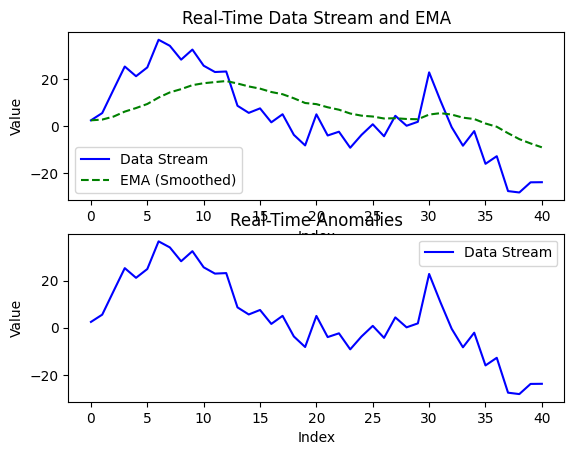

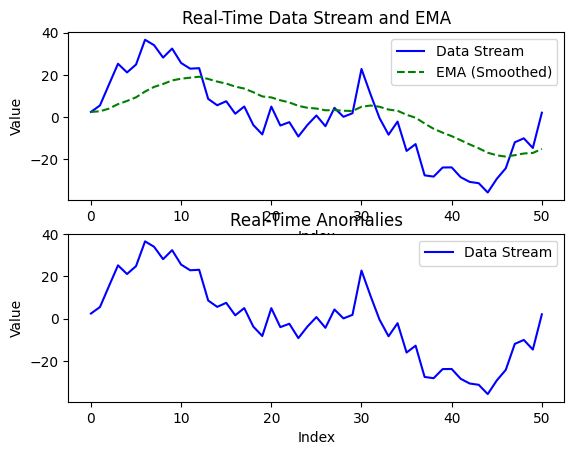

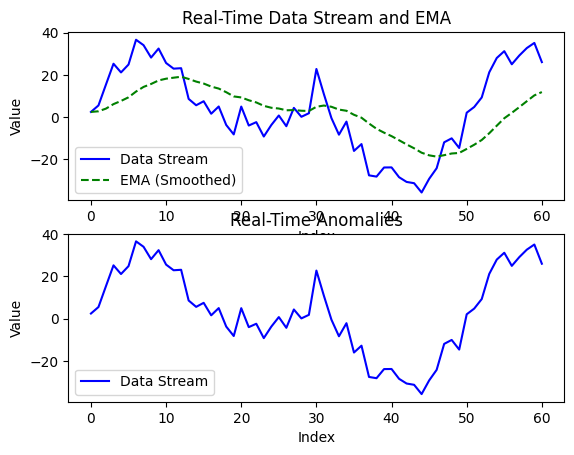

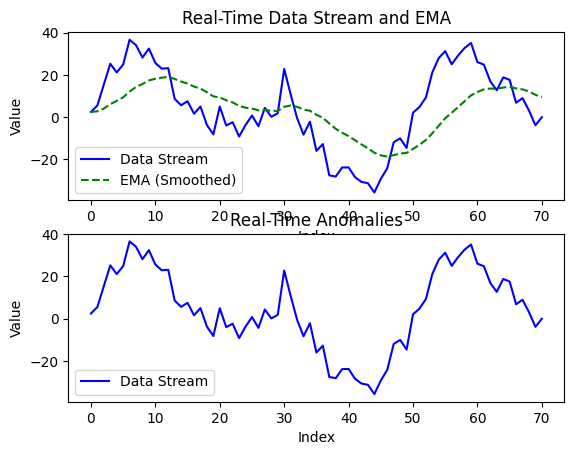

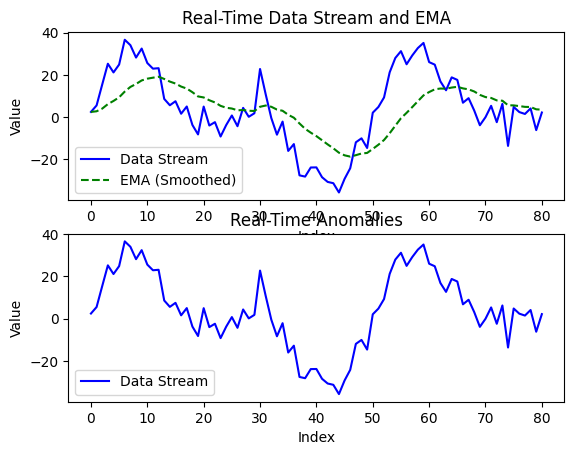

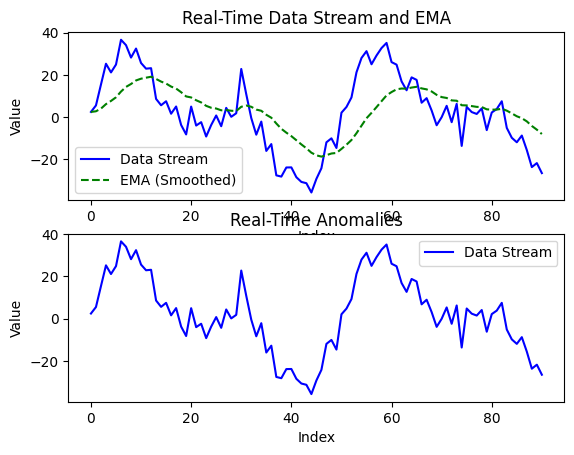

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Step 1: Data Stream Simulation
def make_data_stream_pattern_with_noise_trend(size=100, seasonality=50, noise_level=5, anomaly_rate=0.01):
    np.random.seed(42)
    t = np.arange(size)

    # Multiple seasonal patterns
    seasonal_pattern_1 = 20 * np.sin(2 * np.pi * t / seasonality)
    seasonal_pattern_2 = 15 * np.sin(2 * np.pi * t / (seasonality // 2))

    # Combine seasonal patterns
    seasonal_pattern = seasonal_pattern_1 + seasonal_pattern_2

    # Add noise and a trend
    noise = noise_level * np.random.randn(size)
    trend = 0.01 * t

    # Generate the data stream
    data_stream_pattern_with_noise_trend = seasonal_pattern + noise + trend

    # Add anomalies by introducing large spikes
    number_anomalies = int(size * anomaly_rate)
    anomaly_indices = np.random.choice(size, number_anomalies, replace=False)
    data_stream_pattern_with_noise_trend[anomaly_indices] += np.random.randint(20, 50, number_anomalies)

    return data_stream_pattern_with_noise_trend, anomaly_indices

# Step 2: Anomaly Detection
class RefinedAnomalyDetector:
    def __init__(self, window_size=50, ema_alpha=0.1, z_threshold=3):
        self.window_size = window_size
        self.ema_alpha = ema_alpha
        self.z_threshold = z_threshold

    def detect(self, data_stream_pattern_with_noise_trend):
        ema_value = None
        data_window = []
        anomalies = []

        for idx, value in enumerate(data_stream_pattern_with_noise_trend):
            # Calculate EMA
            if ema_value is None:
                ema_value = value
            else:
                ema_value = self.ema_alpha * value + (1 - self.ema_alpha) * ema_value

            # Add data point to window
            data_window.append(value)
            if len(data_window) > self.window_size:
                data_window.pop(0)

            # Calculate Z-score if enough data points
            if len(data_window) == self.window_size:
                mean = np.mean(data_window)
                std_dev = np.std(data_window)

                if std_dev > 0:
                    z_score = (value - mean) / std_dev
                    if np.abs(z_score) > self.z_threshold:
                        anomalies.append((idx, value))  # Record anomaly

            # Yield the current index, value, ema, and any detected anomalies
            yield idx, value, ema_value, anomalies
            anomalies = []  # Reset anomalies for the next iteration

# Step 3: Visualization
def plot_comparison(data_stream_pattern_with_noise_trend, ema_points, anomaly_indices, anomaly_values):
    plt.figure(figsize=(18, 14))

    # Plot 1: Original Data Stream vs. Smoothed Data
    plt.subplot(3, 2, 1)
    plt.plot(data_stream_pattern_with_noise_trend, label='Data Stream', color='blue')
    plt.plot(ema_points, label='EMA (Smoothed)', linestyle='--', color='green')
    plt.title('Data Stream and EMA')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

    # Plot 2: Data Stream with Anomalies Highlighted
    plt.subplot(3, 2, 2)
    plt.plot(data_stream_pattern_with_noise_trend, label='Data Stream', color='blue')
    if anomaly_indices:
        plt.scatter(anomaly_indices, [data_stream_pattern_with_noise_trend[i] for i in anomaly_indices], color='red', label='Anomalies', marker='x')
    plt.title('Data Stream with Anomalies')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

    # Plot 3: Rolling Statistics (Mean and Std Dev)
    rolling_mean = pd.Series(data_stream_pattern_with_noise_trend).rolling(window=50).mean()
    rolling_std = pd.Series(data_stream_pattern_with_noise_trend).rolling(window=50).std()
    plt.subplot(3, 2, 3)
    plt.plot(data_stream_pattern_with_noise_trend, label='Data Stream', color='blue', alpha=0.5)
    plt.plot(rolling_mean, label='Rolling Mean', color='green')
    plt.plot(rolling_std, label='Rolling Std Dev', color='orange')
    plt.title('Rolling Mean and Std Dev')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

    # Plot 4: Histogram of Data Distribution
    plt.subplot(3, 2, 4)
    plt.hist(data_stream_pattern_with_noise_trend, bins=50, color='blue', alpha=0.7)
    plt.title('Histogram of Data Stream')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Plot 5: Histogram of Anomalies
    plt.subplot(3, 2, 5)
    if anomaly_values:
        plt.hist(anomaly_values, bins=50, color='red', alpha=0.7)
    plt.title('Histogram of Anomalies')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # Plot 6: Anomalies Over Time
    plt.subplot(3, 2, 6)
    plt.plot(data_stream_pattern_with_noise_trend, label='Data Stream', color='blue')
    plt.scatter(anomaly_indices, [data_stream_pattern_with_noise_trend[i] for i in anomaly_indices], color='red', label='Anomalies', marker='x')
    plt.title('Anomalies Over Time')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Step 4: Real-Time Data Stream Simulation
def real_time_simulation(detector, data_stream_pattern_with_noise_trend, interval=10):
    data_points, ema_points = [], []
    anomaly_indices_out = []
    anomaly_values = []

    for idx, value, ema_value, anomalies in detector.detect(data_stream_pattern_with_noise_trend):
        data_points.append(value)
        ema_points.append(ema_value)

        if anomalies:
            anomaly_idx, anomaly_val = zip(*anomalies)
            anomaly_indices_out.extend(anomaly_idx)
            anomaly_values.extend(anomaly_val)

        if idx % interval == 0:  # Update every `interval` data points
            plt.clf()
            plt.subplot(2, 1, 1)
            plt.plot(data_points, label='Data Stream', color='blue')
            plt.plot(ema_points, label='EMA (Smoothed)', linestyle='--', color='green')
            plt.title('Real-Time Data Stream and EMA')
            plt.xlabel('Index')
            plt.ylabel('Value')
            plt.legend()

            plt.subplot(2, 1, 2)
            if anomaly_indices_out:
                plt.scatter(anomaly_indices_out, [data_points[i] for i in anomaly_indices_out], color='red', label='Anomalies', marker='x')
            plt.plot(data_points, label='Data Stream', color='blue')
            plt.title('Real-Time Anomalies')
            plt.xlabel('Index')
            plt.ylabel('Value')
            plt.legend()

            plt.pause(0.01)

    plt.show()

# Main execution
if __name__ == "__main__":
    # Generate data stream
    data_stream_pattern_with_noise_trend, anomaly_indices = make_data_stream_pattern_with_noise_trend()

    # Initialize detector
    detector = RefinedAnomalyDetector(window_size=50, ema_alpha=0.1, z_threshold=3)

    # Collect data for visualization
    data_points, ema_points = [], []
    anomaly_indices_out = []
    anomaly_values = []

    for idx, value, ema_value, anomalies in detector.detect(data_stream_pattern_with_noise_trend):
        data_points.append(value)
        ema_points.append(ema_value)

        if anomalies:
            anomaly_idx, anomaly_val = zip(*anomalies)
            anomaly_indices_out.extend(anomaly_idx)
            anomaly_values.extend(anomaly_val)

    # Plot data and anomalies
    plot_comparison(data_stream_pattern_with_noise_trend, ema_points, anomaly_indices_out, anomaly_values)

    # Real-time simulation (optional)
    real_time_simulation(detector, data_stream_pattern_with_noise_trend)
